<a href="https://colab.research.google.com/github/kranov582/mvp-2-parte-2/blob/main/mvp-2-parte-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Machine Learning & Analytics - Parte 2

>


## Pedro Augusto Boller


## 1 Definição do Problema

O presente trabalho tem como objetivo a aplicação de técnicas avançadas de Deep Learning para treinar um modelo de inteligência artificial, a fim de resolver um desafio de processamento de linguagem natural.

O problema em questão refere-se a um conjunto de dados composto por títulos e sinopses de filmes em língua inglesa. O objetivo principal é utilizar essas informações para desenvolver um sistema capaz de prever automaticamente o gênero do filme com base em seus atributos textuais.

A tarefa de classificação de gênero de filmes a partir de textos representa um desafio complexo devido à natureza subjetiva dos rótulos e às nuances inerentes à análise de linguagem natural. Portanto, a utilização de técnicas de Deep Learning se mostra promissora para capturar as relações latentes entre as características textuais e os gêneros dos filmes.

O conjunto de dados utilizado neste trabalho foi obtido na plataforma Hugging Face, como parte de uma competição específica de classificação de gênero de filmes. Para acessar os dados, é necessário se inscrever e validar o login na plataforma através do seguinte link:

https://huggingface.co/spaces/competitions/movie-genre-prediction

No entanto, devido a restrições de compartilhamento, o notebook não pode ser fornecido diretamente com a chave de acesso à plataforma. Para contornar essa limitação, o conjunto de dados foi baixado e armazenado em um repositório do GitHub, permitindo sua importação para o ambiente de desenvolvimento.

Os atributos presentes no dataset são os seguintes:

**id**: Id unico de cada filme\
**movie_name**: Nome do filme\
**synopsis**: Sinopse do filme\
**genre**: O genero do filme

Os generos presentes são os seguintes:

*   action
*   adventure
*   crime
*   family
*   fantasy
*   horror
*   mystery
*   romance
*   scifi
*   thriller

In [1]:
# instalando dependências
! pip install transformers[torch] datasets evaluate scikit-learn matplotlib
! pip install gdown


import os
import pandas as pd
from datasets import load_dataset, Dataset, concatenate_datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

import seaborn as sns
import matplotlib.pyplot as plt

import gdown
import zipfile

import numpy as np
import evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.3 MB/s eta 0:00:00


### 1.1 Carga do dataset

O primeiro passo antes de tudo é carregar o dataset. Como foi explicado na sessão anterior, os dados estão localizados no github.

In [2]:
# carregando dados locais

train_path = 'https://raw.githubusercontent.com/kranov582/mvp-2-parte-2/main/dataset_pd_train.csv'
test_path = 'https://raw.githubusercontent.com/kranov582/mvp-2-parte-2/main/dataset_pd_test.csv'

dataset = load_dataset('csv', data_files={'train': train_path , 'test': test_path},
                              column_names=['id','movie_name','synopsis','genre'], skiprows=[0])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a0b1ba23bbe1596d/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
treino = pd.read_csv('https://raw.githubusercontent.com/kranov582/mvp-2-parte-2/main/dataset_pd_train.csv')
treino.head()

,id,movie_name,synopsis,genre
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy
1,50185,Entity Project,A director and her friends renting a haunted h...,horror
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action


In [4]:
set(dataset["train"]["genre"])

{'action',
 'adventure',
 'crime',
 'family',
 'fantasy',
 'horror',
 'mystery',
 'romance',
 'scifi',
 'thriller'}

## 2 Preparação de Dados

Antes de realizar o treinamento do modelo, é necessario fazer a preparação dos dados.

### 2.1 Balanceamento

Como é possivel ver abaixo, o dataset de teste esta totalmente desbalanceado, contendo apenas dados da classe "action". Por este motivo, será necessario executar uma etapa de balanceamento dos dados.

Como é possivel ver abaixo, o dataset está divido em treino (com 54000 linhas) e teste (com 36000 linhas).

No dataset de treino, contamos com 5400 valores de cada uma das classes (ou seja, é um dataset totalmente balanceado). Porém, no dataset de teste, existe apenas uma classe.

In [5]:
dataset_pd_test = dataset["test"].to_pandas()
dataset_pd_train = dataset["train"].to_pandas()

In [6]:
dataset_pd_test.shape

(36000, 4)

In [7]:
print(dataset_pd_test.groupby(by='genre').count())

           id  movie_name  synopsis
genre                              
action  36000       36000     36000


In [8]:
dataset_pd_train.shape

(54000, 4)

In [9]:
print(dataset_pd_train.groupby(by='genre').count())

             id  movie_name  synopsis
genre                                
action     5400        5400      5400
adventure  5400        5400      5400
crime      5400        5400      5400
family     5400        5400      5400
fantasy    5400        5400      5400
horror     5400        5400      5400
mystery    5400        5400      5400
romance    5400        5400      5400
scifi      5400        5400      5400
thriller   5400        5400      5400


Abaixo é possivel ver estas informações graficamente. Ao juntar os dois datasets, podemos notar que a quantidade de linhas com a classe "action" é muito maior que as outras.

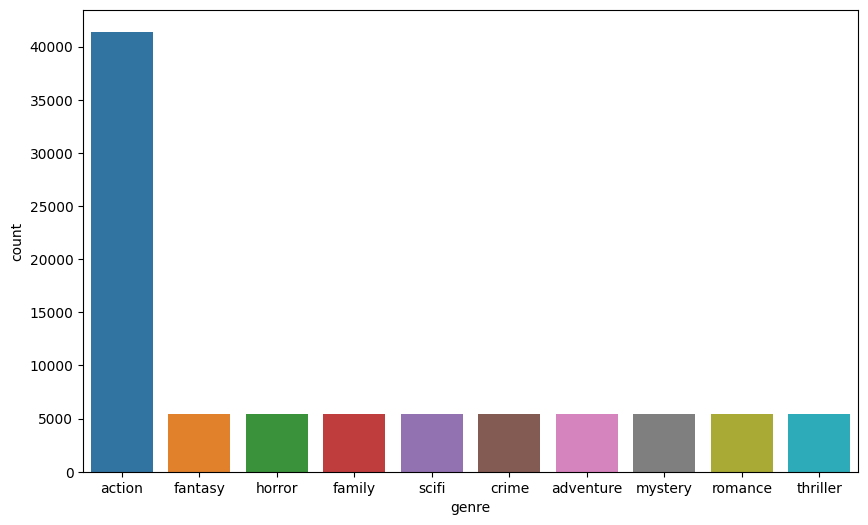

In [10]:
data = pd.concat([dataset_pd_test, dataset_pd_train], axis=0)

plt.figure(figsize=(10, 6))

sns.countplot(x=data['genre'], data=data)
plt.show()

In [11]:
data_group = data.groupby('genre').count()
data_group

,id,movie_name,synopsis
genre,,,
action,41400,41400,41400
adventure,5400,5400,5400
crime,5400,5400,5400
family,5400,5400,5400
fantasy,5400,5400,5400
horror,5400,5400,5400
mystery,5400,5400,5400
romance,5400,5400,5400
scifi,5400,5400,5400


Para resolver este problema, retirei uma subamostragem aleatoria da classe majoritaria, e criei um dataset balanceado a partir dela:

In [12]:

# Numero de classes
class_counts = 10

# Numero de contagens por classe
min_count = 5400

balanced_data_pd = pd.DataFrame()

# Realizando a subamostragem aleatória da classe majoritária
for class_label, group in data.groupby('genre'):
    sampled_group = group.sample(n=min_count, random_state=9)
    balanced_data_pd = pd.concat([balanced_data_pd, sampled_group])

# Exibindo o dataset balanceado
print(balanced_data_pd['genre'].value_counts())

action       5400
adventure    5400
crime        5400
family       5400
fantasy      5400
horror       5400
mystery      5400
romance      5400
scifi        5400
thriller     5400
Name: genre, dtype: int64


In [13]:
# Transformando o dataset do pandas para o do hugging face
balanced_data = Dataset.from_pandas(balanced_data_pd)

# Separando em dados de treino e teste
dataset = balanced_data.train_test_split(test_size=0.2)

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'movie_name', 'synopsis', 'genre', '__index_level_0__'],
        num_rows: 43200
    })
    test: Dataset({
        features: ['id', 'movie_name', 'synopsis', 'genre', '__index_level_0__'],
        num_rows: 10800
    })
})

### 2.2 Preparação dos atributos

Agora que o dataset está balanceado, será necessario juntar o texto do titulo com o texto da sinopse dos filmes, pois o modelo utiliza apenas uma entrada para prever os labels. Foi adicionado um separador "[SEP]" para separar os dois textos diferentes.

In [15]:
# Função para juntar as features
def merge_text_features(example):
    movie_name = example["movie_name"]
    synopsis = example["synopsis"]
    example["text"] = movie_name + "[SEP]" + synopsis
    return example

# Renomear a feature "genre" para "labels"
dataset = dataset.rename_column("genre", "label")

# Aplicando no dataset de treino
dataset["train"] = dataset["train"].map(merge_text_features)
# Aplicando no dataset de teste
dataset["test"] = dataset["test"].map(merge_text_features)

# Removendo as colunas que não serão mais usadas
dataset = dataset.remove_columns(["id", "movie_name", "synopsis", "__index_level_0__"])

# Classificando a coluna "label" como a target
dataset = dataset.class_encode_column(column="label")

Map:   0%|          | 0/43200 [00:00<?, ? examples/s]

Map:   0%|          | 0/10800 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/43200 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/10800 [00:00<?, ? examples/s]

In [16]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 43200
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 10800
    })
})


In [17]:
set(dataset["train"]["label"])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## 3 Modelagem e Treinamento

Nesta etapa os dados serão processados e transformados em tokens, para assim serem alimentados ao modelo para fazer o treinamento.

O modelo que será utilizado para o treinamento será o BERT na versão base, com case-sensetive.

Devido as limitações de uso de GPU do Colab, não foi possivel concluir todo o treinamento aqui, e por isso a maior parte das etapas foram feitas em outro ambiente(kaggle). Devido a isso, as células de código a seguir tem um caráter demonstrativo, mas podem ser executadas para realizar o treinamento, pois todos os hiperparametros já estão configurados.

In [18]:
# Separando o dataset de treino e o de validação
train = dataset["train"].shuffle(seed=9).select(range(42200))
eval = dataset["train"].shuffle(seed=9).select(range(42200,43200))

# Dataset de teste
test = dataset["test"]

In [19]:
# Carregando o modelo e o tokenizer
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=10)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", trainable = True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [20]:
# Aplicando o tokenizer

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train_dataset = train.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval.map(tokenize_function, batched=True)
tokenized_test_dataset = test.map(tokenize_function, batched=True)

Map:   0%|          | 0/42200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10800 [00:00<?, ? examples/s]

Na célula de código abaixo, será configurado os parametros de treinamento do modelo.

In [21]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

MODEL_PATH = "modelo-bert-movie"

training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    evaluation_strategy="steps",
    eval_steps=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    max_steps=1000,
    learning_rate=3e-5,
    logging_strategy="steps",
    logging_steps=10,
    save_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    disable_tqdm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Código para iniciar o treinamento. Pode ser descomentado para realizar o treinamento pelo colab.

# trainer.train()

## 4 Avaliação de resultados

Nesta etapa, será feito a avaliação do modelo treinado.

Como foi comentado anteriormente, a maior parte do treinamento ocorreu fora do ambiente do colab, devido as limitações de uso. Por isso, para fazer a avaliação do modelo, primeiramente será necessario importar todos os dados a partir do google drive.

In [ ]:
# Código necessario apenas se o treinamento ocorrer no colab
"""
path = '/content/drive/MyDrive/MODELOS_DL/modelo-bert-4'
trainer.save_model(path)
tokenizer.save_pretrained(path)
"""

### 4.1 Carregamento do modelo

In [22]:
# Código para carregar o modelo a partir do google drive

file_id = "1TvwGae1I08fRjeLUGGAOkPk8uIDpRo1V"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./MODELOS"
os.makedirs(folder_path, exist_ok=True)

output = "MODELOS/modelo-bert-4.zip"
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1TvwGae1I08fRjeLUGGAOkPk8uIDpRo1V
To: /content/MODELOS/modelo-bert-4.zip
100%|██████████| 402M/402M [00:09<00:00, 43.5MB/s]


'MODELOS/modelo-bert-4.zip'

In [ ]:
# Código para extrair os arquivos .zip

destination = 'MODELOS/modelo-bert-4/'

os.makedirs(destination,exist_ok=True)

with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall(destination)

In [30]:
# Código para aplicar o modelo aos dados de teste

model_path = destination
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Configuração do Trainer
trainer = Trainer(model=model)

In [ ]:
trainer.evaluate(tokenized_test_dataset)

### 4.2 Avaliação do log de treinamento

In [29]:
# Código para carregar o log de treinamento do modelo feito no kaggle
log_path = '/content/MODELOS/modelo-bert-4/log.csv'
df_log = pd.read_csv(log_path, index_col = False).drop(columns = 'Unnamed: 0')
df_log.head()

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.3756,0.000030,0.02,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.02,10,2.312972,0.098,19.6288,50.946,3.210,NaN,NaN,NaN,NaN,NaN
2,2.3069,0.000029,0.03,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.03,20,2.280903,0.111,21.2710,47.012,2.962,NaN,NaN,NaN,NaN,NaN
4,2.2671,0.000029,0.05,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


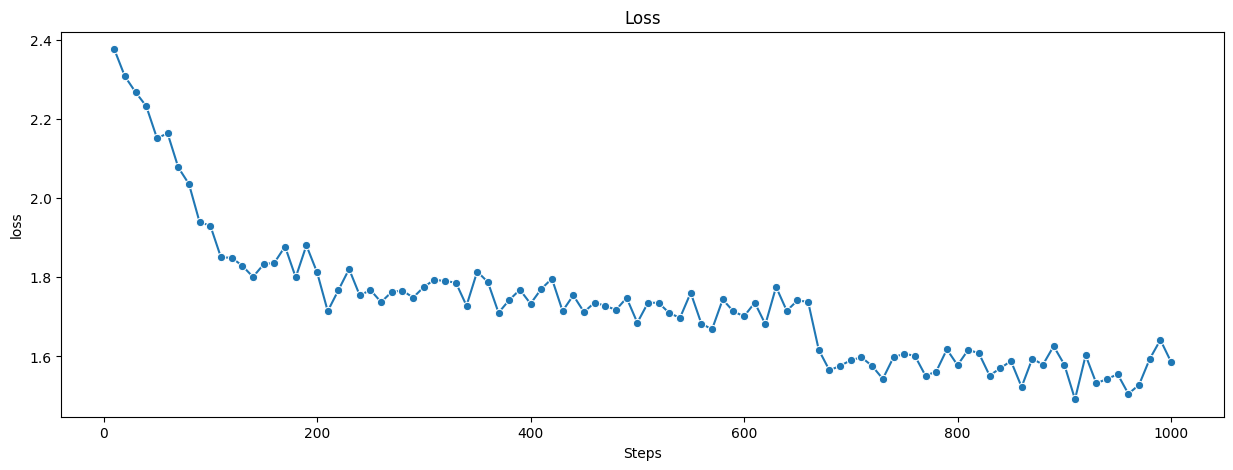

In [ ]:
# Configura o tamanho da plotagem
fig, ax = plt.subplots(figsize=(15, 5))

# Plota o gráfico de linhas usando seaborn
ax = sns.lineplot(x='step', y='loss', data=df_log, ax = ax,
    marker='o', dashes=False)

# Configura o título do gráfico e dos eixos
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('loss')

# Ajustando a área de plotagem para que os valores não fiquem para fora
plt.show()

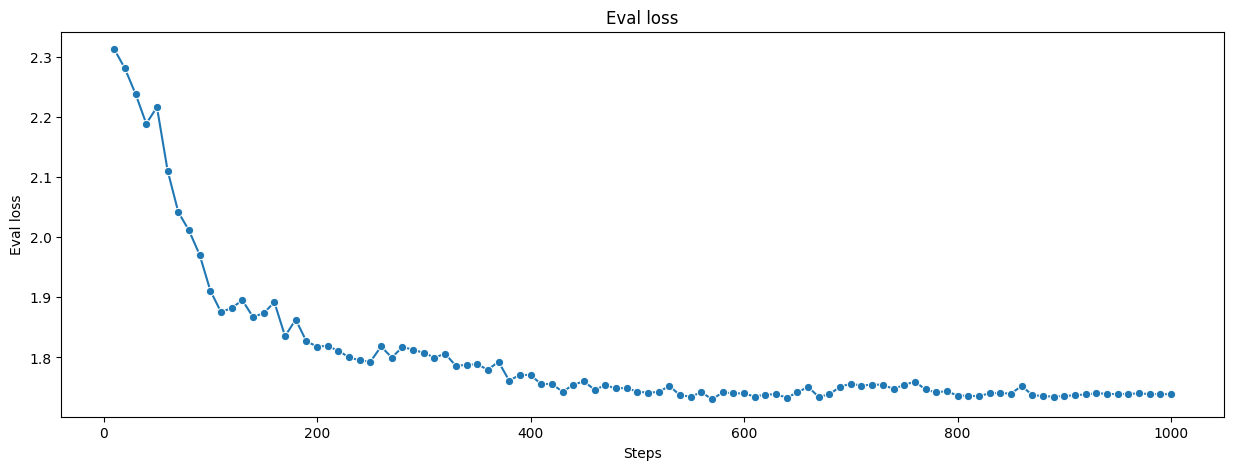

In [ ]:
# Configura o tamanho da plotagem
fig, ax = plt.subplots(figsize=(15, 5))

# Plota o gráfico de linhas usando seaborn
ax = sns.lineplot(x='step', y='eval_loss', data=df_log, ax = ax,
    marker='o', dashes=False)

# Configura o título do gráfico e dos eixos
plt.title('Eval loss')
plt.xlabel('Steps')
plt.ylabel('Eval loss')

# Ajustando a área de plotagem para que os valores não fiquem para fora
plt.show()

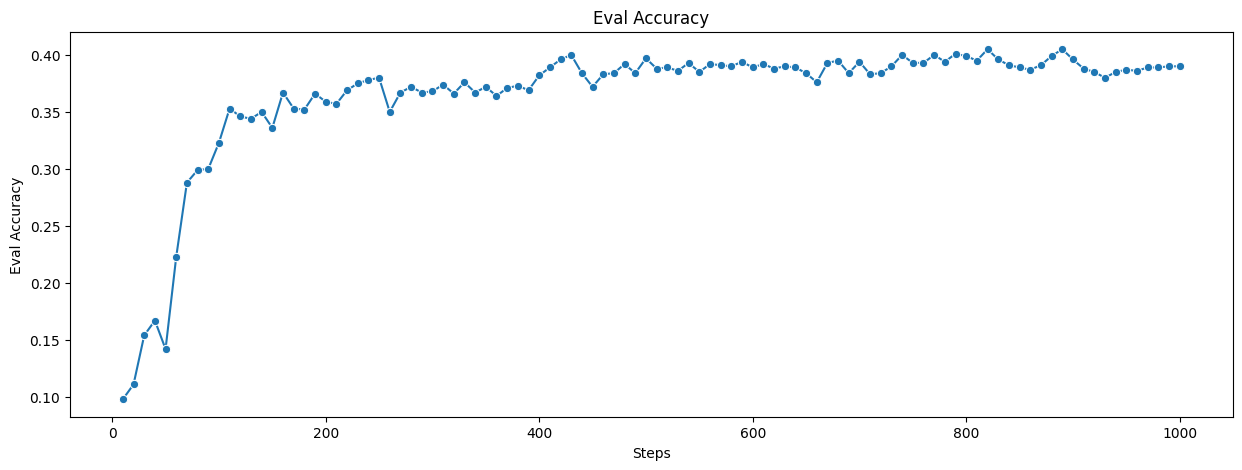

In [ ]:
# Configura o tamanho da plotagem
fig, ax = plt.subplots(figsize=(15, 5))

# Plota o gráfico de linhas usando seaborn
ax = sns.lineplot(x='step', y='eval_accuracy', data=df_log, ax = ax,
    marker='o', dashes=False)

# Configura o título do gráfico e dos eixos
plt.title('Eval Accuracy')
plt.xlabel('Steps')
plt.ylabel('Eval Accuracy')

# Ajustando a área de plotagem para que os valores não fiquem para fora
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/MODELOS_DL/modelo-bert-3'
output_path = '/content/drive/MyDrive/MODELOS_DL/modelo-bert-3.zip'

with zipfile.ZipFile(output_path, 'w') as zipf:
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, folder_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test_pd = test.to_pandas()
test_pd.head()

,label,text
0,3,Magic to Love[SEP]Romance and fantasy mix in t...
1,9,"Viper[SEP]An enormous, genetically altered sna..."
2,8,DISCONN[SEP]Plot being kept under wraps.
3,3,The Big Wish[SEP]Salma is an orphan who has sp...
4,6,369[SEP]When police couldn't tackle a mysterio...


In [ ]:
genre_mapping = {
    0: 'action',
    1: 'adventure',
    2: 'crime',
    3: 'family',
    4: 'fantasy',
    5: 'horror',
    6: 'mystery',
    7: 'romance',
    8: 'sci-fi',
    9: 'thriller'
}

pred_genre = genre_mapping[pred.item()]
print(pred_genre)

family


## 5 Conclusão

In [ ]:
encoded_input

4-fantasy\
5-horror\
3-family\
8-scifi\
0-action\
2-crime\
1-adventure\
6-mistery\
7-romance\
9-thiller